In [1]:
#
#official package
#
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#
# lorenz 96 model by fortran
#
"""
f2py -c -m fortran_model model_time_step.f90で共有ファイル(.so)を作成
Fortran プログラムを Pythonで利用する
(python version 3.8)
"""
import fortran_model as FModel

### Fmodel の引数の確認

In [2]:
print(FModel.lorenz_model.__doc__)

'd'-scalar
'd'-scalar
p_out = model_right_term(p_in,[n])

Wrapper for ``model_right_term``.

Parameters
----------
p_in : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: len(p_in)

Returns
-------
p_out : rank-1 array('d') with bounds (n)
x_out = runge_kutta_method(x_in,[n])

Wrapper for ``runge_kutta_method``.

Parameters
----------
x_in : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: len(x_in)

Returns
-------
x_out : rank-1 array('d') with bounds (n)
mm = kf_matrix_get_m(x_init,t_step,alpha,[n])

Wrapper for ``kf_matrix_get_m``.

Parameters
----------
x_init : input rank-1 array('d') with bounds (n)
t_step : input int
alpha : input float

Other Parameters
----------------
n : input int, optional
    Default: len(x_init)

Returns
-------
mm : rank-2 array('d') with bounds (n,n)



## Lorenz 96 model
- NN: 変数ベクトルXの次元 (通常40)
- FF: 外力
- dt: モデルの１積分時間

FF, dt はFortranプログラムの中で定義されており書き換えはできないことに注意

In [3]:
#
#モデルの変数
#
NN = 40
FF = 8.0
dt = 0.01

#
#初期値
#
XX_IN = np.ones(NN, dtype=np.float64)*FF
XX_IN[19] = FF + FF/100
print("初期値 X0 =\n{}".format(XX_IN))

#
#作業変数
#
XX_OUT = np.zeros_like(XX_IN, dtype=np.float64)

#
#時間発展
#
for idx_time in range(10000):
    XX_OUT = FModel.lorenz_model.runge_kutta_method(XX_IN,NN)
    XX_IN = XX_OUT
print("XX =\n{}".format(XX_IN))

初期値 X0 =
[8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.
 8.   8.   8.   8.   8.   8.08 8.   8.   8.   8.   8.   8.   8.   8.
 8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.  ]
XX =
[-0.3872175  -1.33058325  5.46683401  3.80535761 -2.48410819  2.43179988
  6.92025273 -5.22766098 -0.29894255  1.05323256  4.27435197  8.09364269
  0.04964911 -1.0032037   2.5989576   5.82325104 -0.92156635 -2.88815275
  0.15206707  2.2693181   7.1402882  -0.65889619 -1.25073055  0.69132582
 -1.45871217  0.754673   10.24855452  5.76276533  3.75469751  4.96874855
  3.5307819   0.98523229 -5.07164707  5.84708415  2.40041495  2.00469413
  9.25834708  2.23924377 -1.10619949 -1.07705475]


## 接線形行列の計算
### FModel.lorenz_model.kf_matrix_get_m( XX_IN,  assim_step, alpha)
- XX_IN:       １ステップ前のデータ同化の解析値ベクトル(40変数)
- assim_step:  １データ同化においての時間積分回数(6時間に一回の場合は4)
- alpha:       解析値ベクトルに与える摂動の大きさ(1e-3~1e-N 程度に変化させて行列Mが十分収束しておけばよい)

In [4]:
assim_step = 4
alpha = 1e-4

MM = FModel.lorenz_model.kf_matrix_get_m(XX_IN, assim_step, alpha)
print("MM shape :{}".format(MM.shape))

MM shape :(40, 40)


## 行列の可視化
- 誤差の発達は対角成分の寄与を受けることがわかる
- $$
P^f_n = M P^a_{n-1} M^T
$$

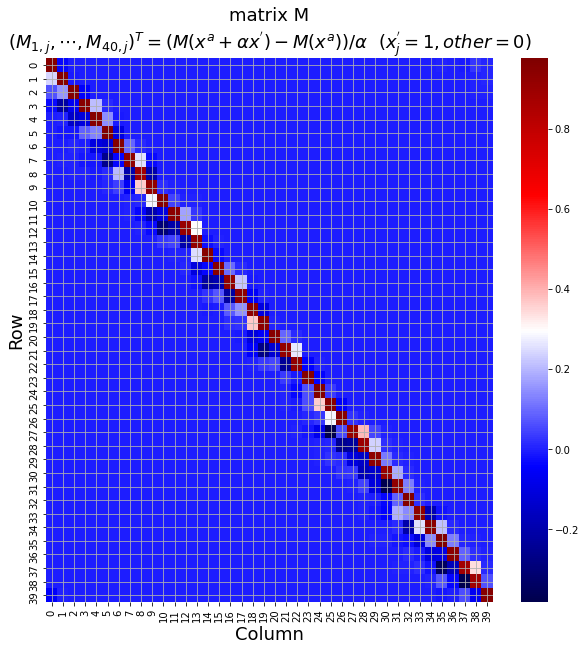

In [8]:
fs = 18

plt.figure(figsize=(10,10))
plt.title("matrix M\n$(M_{1,j}, \cdots, M_{40,j})^T = ( M(x^a + \\alpha x^{'}) - M(x^a) )/\\alpha \ \ (x^{'}_j=1, other =0)$", fontsize=fs)
sns.heatmap(MM, cmap="seismic")
plt.xlabel("Column", fontsize=fs)
plt.ylabel("Row", fontsize=fs)
plt.grid()
plt.show()